# Coding CNNs from Scratch with Pytorch

In this assignment you will code a famous CNN architecture AlexNet (https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) to classify images from the CIFAR10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 10 classes of natural images such as vehicles or animals. AlexNet is a landmark architecture because it was one of the first extremely deep CNNs trained on GPUs, and achieved state-of-the-art performance in the ImageNet challenge in 2012. 


A lot of code will already be written to familiarize yourself with PyTorch, but you will have to fill in parts that will apply your knowledge of CNNs. Additionally, there are some numbered questions that you must answer either in a separate document, or in this notebook. Some questions may require you to do a little research. To type in the notebook, you can insert a text cell. 

Let's start by installing PyTorch and the torchvision package below. Due to the size of the network, you will have to run on a GPU. So, click on the Runtime dropdown, then Change Runtime Type, then GPU for the hardware accelerator. 

In [ ]:
!pip install pytorch
!pip install torchvision

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


device = torch.device('cuda')
    
print(device)

### 1. In the following cell, we are employing something called "data augmentation" with random horizontal and vertical flips. So when training data is fed into the network, it is ranadomly transformed. What are advantages of this?



The main advantage of this data augmentation is to make the training process more robust. That is, adding more variability to the training data should allow the trained classifier to be able to better generalize outside of the original (non-augmented) dataset. We don't want the classifier to learn that the orientation of an object is important in its classification. Rather, we want the features relating to the object itself to be the most important factors in classification.

### 2. We normalize with the line transforms.Normalize((0.5,), (0.5,)). What are the benefits of normalizing data? 


The benefits of normalizing data are to aid the optimization process. With unnormalized data - especially data for which its features have very different scales - the optimization process can take much longer to converge.

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from math import ceil

BATCH_SIZE = 100


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5), 
     transforms.RandomVerticalFlip(p=0.5),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

torch.manual_seed(43)
val_size = 10000
train_size = len(trainset) - val_size


train_ds, val_ds = random_split(trainset, [train_size, val_size])
print(len(train_ds), len(val_ds))


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_steps =  ceil(len(train_ds) / BATCH_SIZE)
num_steps

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
40000 10000


400

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE, shuffle=True, drop_last = True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(testset, BATCH_SIZE)

You can insert an integer  into the code trainset[#insert integer] to visualize images from the training set. Some of the images might look weird because they have been randomly flipped according to our data augmentation scheme. 

Label (numeric): 9
Label (textual): truck


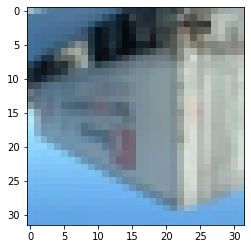

In [ ]:
img, label = trainset[15]
plt.imshow((img.permute((1, 2, 0))+1)/2)
print('Label (numeric):', label)
print('Label (textual):', classes[label])

Now comes the fun part. You will have to put in the correct parameters into different torch.nn functions in order to convolve and downsample the image into the correct dimensionality for classification. Think of it as a puzzle. You will insert the parameters where there is a comment #TODO. 

In [ ]:
class Discriminator(torch.nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            # nn.Conv2d(in_channels = #TODO,
            nn.Conv2d(in_channels = 3,
                      # out_channels = #TODO,
                      out_channels = 64,
                      kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, 
                      # padding=#TODO),
                      padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # nn.Conv2d(#TODO, 
            nn.Conv2d(192, 
                      # TODO,
                      384,
                      kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
            
        #Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            # nn.Linear(#TODO),
            nn.Linear(1024, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            # nn.Linear(4096, #TODO),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            # nn.Linear(4096, #TODO),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        #we must flatten our feature maps before feeding into fully connected layers
        # x = x.contiguous().view(x.size(0), #TODO)
        x = x.contiguous().view(x.size(0), -1)
        x = self.classifier(x)
        return x

Below we are initializing our model with a weight scheme.

In [ ]:
net = Discriminator()

def weights_init(m):

    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)


# Initialize Models
net = net.to(device)

net.apply(weights_init)



Discriminator(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0

# 3. Notice above in our network architecture, we have what are called "Dropout" layers. What is the point of these?

The point of Dropout layers is to prevent overfitting. That is, we don't want to overfit to the entire set of weights, so randomly dropping some subset of weights at certain points in the network allows the training process to be more robust.

Defining our cost/loss function, which is cross-entropy loss. We also define our optimizer with hyperparameters: learning rate and betas. 

In [ ]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    net.parameters(),
    # lr=0.0002,
    lr=0.003,
    betas = (0.5, 0.999)
)


Below we actually train our network. Run for just 10 epochs. It takes some time. Wherever there is the comment #TODO, you must insert code.

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        # labels = #TODO
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        # outputs = #TODO     #pass input data into network to get outputs
        outputs = net.forward(inputs)     #pass input data into network to get outputs
        # loss = criterion(#TODO)
        loss = criterion(outputs, target = labels)
        loss.backward()  #calculate gradients
        optimizer.step() #take gradient descent step

        
        running_loss += loss.item()
            
    
    print("E:{}, Train Loss:{}".format(
                epoch+1,
                running_loss / num_steps
            )
        )
        
        
        
    #validation
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            #TODO: load images and labels from validation loader
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # outputs = #TODO  #run forward pass
            outputs = net.forward(images)  #run forward pass
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                
            # loss = #TODO       #calculate validation loss
            loss = criterion(outputs, target = labels)       #calculate validation loss
            val_loss += loss.item()
    val_loss /=num_steps
    print('Accuracy of 10000 val images: {}'.format( correct / total))
    print('Val Loss: {}'.format( val_loss))

print('Finished Training')

E:1, Train Loss:2.371356721520424
Accuracy of 10000 val images: 0.0955
Val Loss: 0.5758462142944336
E:2, Train Loss:2.3030029767751694
Accuracy of 10000 val images: 0.102
Val Loss: 0.5756686723232269
E:3, Train Loss:2.3030492889881136
Accuracy of 10000 val images: 0.095
Val Loss: 0.5757252484560013
E:4, Train Loss:74.26104119122029
Accuracy of 10000 val images: 0.1032
Val Loss: 0.5787391763925552
E:5, Train Loss:2.2804071885347366
Accuracy of 10000 val images: 0.1458
Val Loss: 0.5518154859542846
E:6, Train Loss:2.203412861227989
Accuracy of 10000 val images: 0.1791
Val Loss: 0.5303513216972351
E:7, Train Loss:2.1344329687952994
Accuracy of 10000 val images: 0.2229
Val Loss: 0.5179587718844414
E:8, Train Loss:2.0419097074866297
Accuracy of 10000 val images: 0.231
Val Loss: 0.5070284867286682
E:9, Train Loss:1.999511862397194
Accuracy of 10000 val images: 0.2484
Val Loss: 0.4974677008390427
E:10, Train Loss:1.9640996858477593
Accuracy of 10000 val images: 0.2688
Val Loss: 0.4869223383069

## 4. If we train for more epochs, our accuracy/performance will increase. What happens if we train for too long though? What method can be employed to mitigate this?


If we train for too long, we could run into issues where we overfit to the training data. One method that can be employed to mitigate this is early-stopping based on our metrics for the validation set. That is, tracking the validation metrics at each epoch, and selecting the network at the epoch which performed the best on the validation set.


## 5. Try increasing learning rate and look at the metrics for training and validation data? What do you notice? Why do think this is happening?

Increasing the learning rate from .0002 to .003, we see that rather than both training and validaiton metrics improving between each epoch (loss decreasing and accuracy increasing), both the training and validation metrics are more unstable, improving between some epochs and worsening between others. It looks like it is still converging overall, but is taking significantly longer to do so. This is likely due to our optimization step skipping over the optimal point rather than approaching it steadily, as the step size is too large.

We can see the performance on the testing set now. 

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of 10000 test images: {}'.format( correct / total))

Accuracy of 10000 test images: 0.2736
